
# Entrega retroalimentacion individual: implementacion de un modelo de deep learning

Liga del dataset: https://www.kaggle.com/datasets/hereisburak/pins-face-recognition

*Utilizamos 25 actores debido a la cantidad de datos que se requieren para subir el data set completo a la nube*

Documentación Keras: https://keras.io/api/applications/

Objetivo: Probar y validar la arquitectura de un modelo pre-entrenado transfer learning VGG 16 con el uso de Keras, hacer fine tuning e implementar una solución más óptima para el proyecto a entregar.



In [3]:
# Importamos el dataset desde la nube
from google.colab import drive
drive.mount('/content/drive')

# Path
source_dir = "/content/drive/MyDrive/DataSetTransferLearning/105_classes_pins_dataset"

Mounted at /content/drive


In [2]:
# Hacemos un split del dataset en subconjuntos de train y test y los asignamos a un nuevo folder
import os
import shutil
from sklearn.model_selection import train_test_split

dest_dir = "/content/drive/MyDrive/DataSetTransferLearning/split_data_set"

os.makedirs(dest_dir, exist_ok=True)
os.makedirs(os.path.join(dest_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(dest_dir, 'test'), exist_ok=True)

actors = os.listdir(source_dir)

# Split de los datos de cada actor a sets de train y test
for actor in actors:
    actor_dir = os.path.join(source_dir, actor)
    images = os.listdir(actor_dir)

    # Split de las imagenes a train y test
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Crear directorio de cada actor en train y test
    os.makedirs(os.path.join(dest_dir, 'train', actor), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'test', actor), exist_ok=True)

    # Mover las imagenenes a su directorio
    for image in train_images:
        shutil.copy(os.path.join(actor_dir, image), os.path.join(dest_dir, 'train', actor, image))

    for image in test_images:
        shutil.copy(os.path.join(actor_dir, image), os.path.join(dest_dir, 'test', actor, image))


In [9]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, Activation, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint


# Ruta de los datos ya divididos en train y test
train_data_dir = '/content/drive/MyDrive/DataSetTransferLearning/split_data_set/train'
test_data_dir = '/content/drive/MyDrive/DataSetTransferLearning/split_data_set/test'

# Parametros
img_width, img_height = 224, 224
batch_size = 32
num_classes = 25  # Cantidad de actores y clasificaciones
epochs = 50

# Cargamos el modelo pre-entrenado VGG16 sin incluir las capas densas
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# No corremos las capas
for layer in vgg_model.layers:
    layer.trainable = False

model = Sequential()

# Añadimos el modelo VGG16 pre-entrenado
model.add(vgg_model)

# Capas personalizadas
model = Sequential()
model.add(vgg_model)

# Capas personalizadas
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))# Capa de salida, numero de clases

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation y preparacion de los datos
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

# Entrenamiento del modelo
model.fit(train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          epochs=epochs,
          validation_data=test_generator,
          validation_steps=test_generator.samples // batch_size)

# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/DataSetTransferLearning/actor_recognition_model.h5')


Found 3118 images belonging to 25 classes.
Found 767 images belonging to 25 classes.
Epoch 1/50
97/97 [==============================] - 60s 585ms/step - loss: 3.1742 - accuracy: 0.0632 - val_loss: 2.9590 - val_accuracy: 0.1698
Epoch 2/50
97/97 [==============================] - 54s 557ms/step - loss: 2.9347 - accuracy: 0.1131 - val_loss: 2.6458 - val_accuracy: 0.2065
Epoch 3/50
97/97 [==============================] - 55s 568ms/step - loss: 2.7118 - accuracy: 0.1692 - val_loss: 2.3920 - val_accuracy: 0.3016
Epoch 4/50
97/97 [==============================] - 53s 550ms/step - loss: 2.5340 - accuracy: 0.2233 - val_loss: 2.2156 - val_accuracy: 0.3546
Epoch 5/50
97/97 [==============================] - 53s 543ms/step - loss: 2.3771 - accuracy: 0.2576 - val_loss: 2.0211 - val_accuracy: 0.4022
Epoch 6/50
97/97 [==============================] - 56s 575ms/step - loss: 2.2653 - accuracy: 0.2955 - val_loss: 1.9459 - val_accuracy: 0.4470
Epoch 7/50
97/97 [==============================] - 51s 5

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import os
# Creamos diccionario para los actores
data_dir = '/content/drive/MyDrive/DataSetTransferLearning/split_data_set/train'  # Directorio de datos de entrenamiento

actor_names = {}
class_index = 0

# Obtenemos los nombres de los actores con cada folder
actors = os.listdir(data_dir)

# Creamos el diccionario con los nombres de los actores
for actor in actors:
    actor_names[class_index] = actor
    class_index += 1

print("Diccionario de nombres de actores:", actor_names)

Diccionario de nombres de actores: {0: 'pins_Adriana Lima', 1: 'pins_Amanda Crew', 2: 'pins_Alex Lawther', 3: 'pins_alycia dabnem carey', 4: 'pins_Alexandra Daddario', 5: 'pins_Alvaro Morte', 6: 'pins_Anne Hathaway', 7: 'pins_Anthony Mackie', 8: 'pins_amber heard', 9: 'pins_Andy Samberg', 10: 'pins_Avril Lavigne', 11: 'pins_barbara palvin', 12: 'pins_barack obama', 13: 'pins_Bill Gates', 14: 'pins_Ben Affleck', 15: 'pins_Bobby Morley', 16: 'pins_Brian J. Smith', 17: 'pins_Brie Larson', 18: 'pins_camila mendes', 19: 'pins_Chris Evans', 20: 'pins_Brenton Thwaites', 21: 'pins_Christian Bale', 22: 'pins_Chris Hemsworth', 23: 'pins_Chris Pratt', 24: 'pins_Cristiano Ronaldo'}


In [15]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# Cargamos el modelo entrenado
saved_model_path = '/content/drive/MyDrive/DataSetTransferLearning/actor_recognition_model.h5'
model = load_model(saved_model_path)

# Ruta de la imagen a predecir
image_path = '/content/drive/MyDrive/DataSetTransferLearning/split_data_set/test/pins_Anthony Mackie/Anthony Mackie132_459.jpg'

# Cargamos la imagen y la preprocesamos para hacer la prediccion
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.

# Realizamos la prediccion
predictions = model.predict(img_array)

# Decodificamos las predicciones
predicted_class = np.argmax(predictions)
predicted_actor = actor_names[predicted_class]

print("Se predice:", predicted_actor)


1/1 [==============================] - 0s 322ms/step
Se predice: pins_Anthony Mackie


Found 767 images belonging to 25 classes.
24/24 [==============================] - 3s 120ms/step - loss: 0.8088 - accuracy: 0.7458
Accuracy: 0.7457627118644068
Loss: 0.8088144063949585


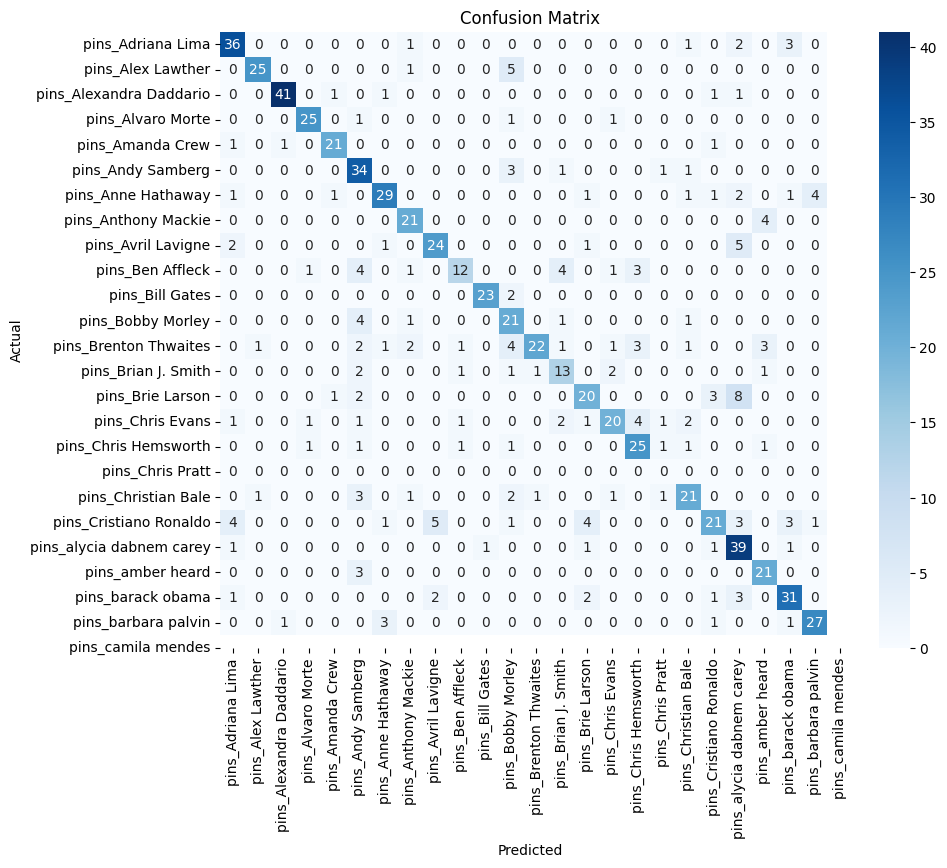

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Data augmentation y preparacion de los datos de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Obtenemos las predicciones del modelo en el conjunto de datos de prueba
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Obtenemos los labels reales
true_classes = test_generator.classes

# Calcular el accuracy y el loss
accuracy = accuracy_score(true_classes, predicted_classes)
loss = model.evaluate(test_generator)[0]  # Perdida en el conjunto de prueba

print("Accuracy:", accuracy)
print("Loss:", loss)

# Creamos y mostramos la matriz de confusion
confusion = confusion_matrix(true_classes, predicted_classes)

# Obtenemos los nombres de las clases
class_names = list(test_generator.class_indices.keys())

# Mostramos la matriz de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
